In [ ]:
"""Adapted from: https://github.com/facebookresearch/esm/blob/main/examples/contact_prediction.ipynb"""

## Imports

In [1]:
# standard lib
from typing import List, Tuple, Optional, Dict, NamedTuple, Union, Callable
import itertools
import os
import string
from pathlib import Path

# scientific libs
import numpy as np
import pandas as pd
from scipy.spatial.distance import squareform, pdist, cdist
from Bio import SeqIO
import biotite.structure as bs
from biotite.structure.io.pdbx import PDBxFile, get_structure
from biotite.database import rcsb

# DL libs
import torch
import torch.nn.functional as F
import esm

# graph libs
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm

torch.set_grad_enabled(False)

## Define Functions

### Parsing alignments

In [2]:
# This is an efficient way to delete lowercase characters from a string
deletekeys = dict.fromkeys(string.ascii_lowercase)
deletekeys["."] = None
deletekeys["*"] = None

def read_sequence(filename: str) -> Tuple[str, str]:
    """ Reads the first (reference) sequences from a fasta file."""
    record = next(SeqIO.parse(filename, "fasta"))
    return record.description, str(record.seq)

### Converting structures to contacts

There are many ways to define a protein contact. Here we're using the definition of 15 angstroms between carbon beta atoms. Note that the position of the carbon beta is imputed from the position of the N, CA, and C atoms for each residue.

In [3]:
def extend(a, b, c, L, A, D):
    """
    input:  3 coords (a,b,c), (L)ength, (A)ngle, and (D)ihedral
    output: 4th coord
    """

    def normalize(x):
        return x / np.linalg.norm(x, ord=2, axis=-1, keepdims=True)

    bc = normalize(b - c)
    n = normalize(np.cross(b - a, bc))
    m = [bc, np.cross(n, bc), n]
    d = [L * np.cos(A), L * np.sin(A) * np.cos(D), -L * np.sin(A) * np.sin(D)]
    return c + sum([m * d for m, d in zip(m, d)])


def contacts_from_pdb(
    structure: bs.AtomArray,
    # Increase distances for flexible IDPs
    distance_threshold: float = 15.0, 
    chain: Optional[str] = None,
) -> np.ndarray:
    mask = ~structure.hetero
    if chain is not None:
        mask &= structure.chain_id == chain

    N = structure.coord[mask & (structure.atom_name == "N")]
    CA = structure.coord[mask & (structure.atom_name == "CA")]
    C = structure.coord[mask & (structure.atom_name == "C")]

    Cbeta = extend(C, N, CA, 1.522, 1.927, -2.143)
    dist = squareform(pdist(Cbeta))
    
    contacts = dist < distance_threshold
    contacts = contacts.astype(np.int64)
    contacts[np.isnan(dist)] = -1
    return contacts

### Compute contact precisions

In [4]:
def compute_precisions(
    predictions: torch.Tensor,
    targets: torch.Tensor,
    src_lengths: Optional[torch.Tensor] = None,
    minsep: int = 12, # increased to only consider medium-long range contacts 
    maxsep: Optional[int] = None,
    override_length: Optional[int] = None,  # for CASP
):
    if isinstance(predictions, np.ndarray):
        predictions = torch.from_numpy(predictions)
    if isinstance(targets, np.ndarray):
        targets = torch.from_numpy(targets)
    if predictions.dim() == 2:
        predictions = predictions.unsqueeze(0)
    if targets.dim() == 2:
        targets = targets.unsqueeze(0)
    override_length = (targets[0, 0] >= 0).sum()

    if predictions.size() != targets.size():
        raise ValueError(
            f"Size mismatch. Received predictions of size {predictions.size()}, "
            f"targets of size {targets.size()}"
        )
    device = predictions.device

    batch_size, seqlen, _ = predictions.size()
    seqlen_range = torch.arange(seqlen, device=device)

    sep = seqlen_range.unsqueeze(0) - seqlen_range.unsqueeze(1)
    sep = sep.unsqueeze(0)
    valid_mask = sep >= minsep
    valid_mask = valid_mask & (targets >= 0)

    if maxsep is not None:
        valid_mask &= sep < maxsep

    if src_lengths is not None:
        valid = seqlen_range.unsqueeze(0) < src_lengths.unsqueeze(1)
        valid_mask &= valid.unsqueeze(1) & valid.unsqueeze(2)
    else:
        src_lengths = torch.full([batch_size], seqlen, device=device, dtype=torch.long)

    predictions = predictions.masked_fill(~valid_mask, float("-inf"))
    
    # minsep masks the short range contacts < 12 residues
    x_ind, y_ind = np.triu_indices(seqlen, minsep)
    predictions_upper = predictions[:, x_ind, y_ind]
    targets_upper = targets[:, x_ind, y_ind]
   
    # Increase top K by three times
    topk_multiplier = 3
    topk = topk_multiplier * seqlen if override_length is None else max(seqlen, override_length)
    
    indices = predictions_upper.argsort(dim=-1, descending=True)[:, :topk]
    topk_targets = targets_upper[torch.arange(batch_size).unsqueeze(1), indices]
    if topk_targets.size(1) < topk:
        topk_targets = F.pad(topk_targets, [0, topk - topk_targets.size(1)])

    cumulative_dist = topk_targets.type_as(predictions).cumsum(-1)

    gather_lengths = src_lengths.unsqueeze(1)
    if override_length is not None:
        gather_lengths = override_length * torch.ones_like(
            gather_lengths, device=device
        )

    gather_indices = (
        torch.arange(0.1, 1.1, 0.1, device=device).unsqueeze(0) * gather_lengths
    ).type(torch.long) - 1

    binned_cumulative_dist = cumulative_dist.gather(1, gather_indices)
    binned_precisions = binned_cumulative_dist / (gather_indices + 1).type_as(
        binned_cumulative_dist
    )

    pl5 = binned_precisions[:, 1]
    pl2 = binned_precisions[:, 4]
    pl = binned_precisions[:, 9]
    auc = binned_precisions.mean(-1)

    return {"AUC": auc, "P@L": pl, "P@L2": pl2, "P@L5": pl5}


def evaluate_prediction(
    predictions: torch.Tensor,
    targets: torch.Tensor,
) -> Dict[str, float]:
    if isinstance(targets, np.ndarray):
        targets = torch.from_numpy(targets)
       
    contact_ranges = [
        ("M", 12, 24),
        ("L", 24, 48),
        ("XL", 48, 96),
        ("XXL", 96, None),
    ]
    metrics = {}
    targets = targets.to(predictions.device)
    for name, minsep, maxsep in contact_ranges:
        rangemetrics = compute_precisions(
            predictions,
            targets,
            minsep=minsep,
            maxsep=maxsep,
        )
        for key, val in rangemetrics.items():
            metrics[f"{name}_{key}"] = val.item()
    return metrics

### Plotting Results

In [5]:
def plot_contacts_and_predictions(
    predictions: Union[torch.Tensor, np.ndarray],
    contacts: Union[torch.Tensor, np.ndarray],
    ax: Optional[mpl.axes.Axes] = None,
    cmap: str = "Blues",
    ms: float = 1,
    title: Union[bool, str, Callable[[float], str]] = True,
    animated: bool = False,
    prediction_threshold: float = 0.5,
) -> None:

    if isinstance(predictions, torch.Tensor):
        predictions = predictions.detach().cpu().numpy()
    if isinstance(contacts, torch.Tensor):
        contacts = contacts.detach().cpu().numpy()
    if ax is None:
        ax = plt.gca()

    # might need to edit    
    seqlen = contacts.shape[0]
    
    relative_distance = np.add.outer(-np.arange(seqlen), np.arange(seqlen))
    
    bottom_mask = relative_distance < 6 
    
    masked_image = np.ma.masked_where(bottom_mask, predictions)
    invalid_mask = np.abs(np.add.outer(np.arange(seqlen), -np.arange(seqlen))) < 6 
    predictions = predictions.copy()
    predictions[invalid_mask] = float("-inf")
    
    # Select only predictions over the threshold that can be resonably predicted
    predictions = predictions > prediction_threshold
       
    topl_val = np.sort(predictions.reshape(-1))[-seqlen]
    pred_contacts = predictions >= topl_val
    true_positives = contacts & pred_contacts & ~bottom_mask
    false_positives = ~contacts & pred_contacts & ~bottom_mask
    other_contacts = contacts & ~pred_contacts & ~bottom_mask

    if isinstance(title, str):
        title_text: Optional[str] = title
    elif title:
        long_range_pl = compute_precisions(predictions, contacts, minsep=12)[  
            "P@L"
        ].item()
        if callable(title):
            title_text = title(long_range_pl)
        else:
            title_text = f"Long Range P@L: {100 * long_range_pl:0.1f}"
    else:
        title_text = None

    img = ax.imshow(masked_image, cmap=cmap, animated=animated)
    oc = ax.plot(*np.where(other_contacts), "o", c="lightgrey", ms=ms)[0]
    fn = ax.plot(*np.where(false_positives), "o", c="red", ms=ms)[0]
    tp = ax.plot(*np.where(true_positives), "o", c="midnightblue", ms=ms)[0]
    ti = ax.set_title(title_text) if title_text is not None else None

    ax.axis("square")
    ax.set_xlim([0, seqlen])
    ax.set_ylim([0, seqlen])

## Predict and Visualize

### Read Data

In [6]:
# Read in data

PDB_IDS = ["6shx"] # ["4e4w"] # ["1a3a", "5ahw", "1xcr"] 

structures = {
    name.lower(): get_structure(PDBxFile.read(rcsb.fetch(name, "cif")))[0]
    for name in PDB_IDS
}

# For MMR examples
contacts = {
    name: contacts_from_pdb(structure)
    # For Repo examples use instead
    # name: contacts_from_pdb(structure, chain="A")
    for name, structure in structures.items()
}

sequences = {
    name: read_sequence(f"data/{name.lower()}.fasta")
    for name in PDB_IDS
}

### ESM-2 Predictions

In [7]:
esm2, esm2_alphabet = esm.pretrained.esm2_t33_650M_UR50D()

esm2_batch_converter = esm2_alphabet.get_batch_converter()

#esm2 = torch.load('trained_model_1024_BCE_6ep.pth') # V1

#esm2 = torch.load("trained_model_tristan_esm2_t33_650M_UR50D_v2.pth") # V2

esm2 = esm2.eval()

In [ ]:
# Repo plots

In [ ]:
# MMR Plots

In [8]:
esm2_predictions = {}
esm2_results = []
for name, inputs in sequences.items():
    esm2_batch_labels, esm2_batch_strs, esm2_batch_tokens = esm2_batch_converter([inputs])
    esm2_batch_tokens = esm2_batch_tokens.to(next(esm2.parameters()).device)
    esm2_predictions[name] = esm2.predict_contacts(esm2_batch_tokens)[0].cpu()
    metrics = {"id": name, "model": "ESM-2 (Unsupervised)"}
    metrics.update(evaluate_prediction(esm2_predictions[name], contacts[name]))
    esm2_results.append(metrics)
esm2_results = pd.DataFrame(esm2_results)
display(esm2_results)

,id,model,M_AUC,M_P@L,M_P@L2,M_P@L5,L_AUC,L_P@L,L_P@L2,L_P@L5,XL_AUC,XL_P@L,XL_P@L2,XL_P@L5,XXL_AUC,XXL_P@L,XXL_P@L2,XXL_P@L5
0,6shx,ESM-2 (Unsupervised),0.73015,0.676349,0.717842,0.770833,0.690955,0.574689,0.697095,0.791667,0.486363,0.338174,0.46473,0.635417,0.754165,0.688797,0.746888,0.8125


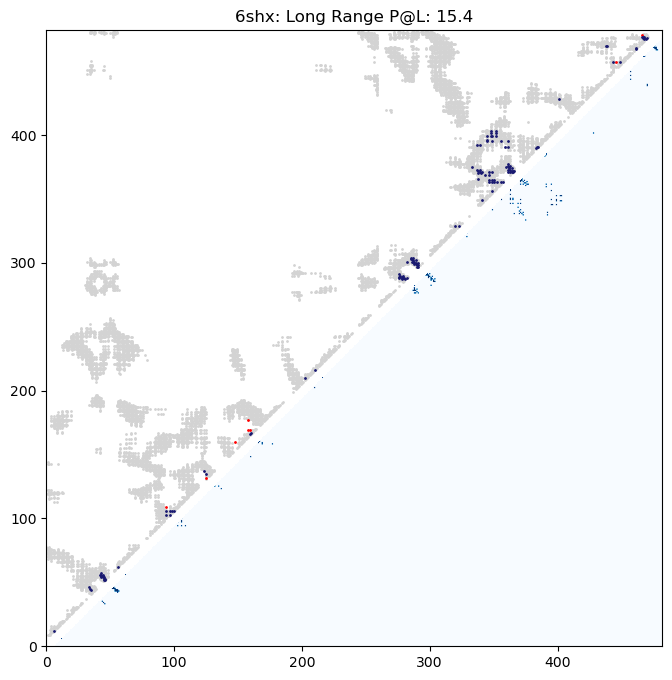

In [11]:
fig, axes = plt.subplots(figsize=(12, 8), ncols=1)
prediction = esm2_predictions[name] > 0.5
target = contacts[name]
plot_contacts_and_predictions(
    prediction, target, title = lambda prec: f"{name}: Long Range P@L: {100 * prec:0.1f}"
)
plt.show()

In [ ]:
# TESTING BLOCK

In [ ]:
# FT V1

In [32]:
esm2_predictions = {}
esm2_results = []
for name, inputs in sequences.items():
    esm2_batch_labels, esm2_batch_strs, esm2_batch_tokens = esm2_batch_converter([inputs])
    esm2_batch_tokens = esm2_batch_tokens.to(next(esm2.parameters()).device)
    esm2_predictions[name] = esm2.predict_contacts(esm2_batch_tokens)[0].cpu()
    metrics = {"id": name, "model": "ESM-2 (Unsupervised)"}
    metrics.update(evaluate_prediction(esm2_predictions[name], contacts[name]))
    esm2_results.append(metrics)
esm2_results = pd.DataFrame(esm2_results)
display(esm2_results)

,id,model,M_AUC,M_P@L,M_P@L2,M_P@L5,L_AUC,L_P@L,L_P@L2,L_P@L5,XL_AUC,XL_P@L,XL_P@L2,XL_P@L5,XXL_AUC,XXL_P@L,XXL_P@L2,XXL_P@L5
0,1a3a,ESM-2 (Unsupervised),0.949868,0.834483,1.000000,1.000000,0.983298,0.958621,1.000000,1.000000,0.966233,0.917241,0.986111,1.000000,0.648847,0.475862,0.652778,0.827586
1,5ahw,ESM-2 (Unsupervised),0.923424,0.840000,0.903226,1.000000,1.000000,1.000000,1.000000,1.000000,0.970532,0.952000,0.951613,1.000000,0.844272,0.728000,0.887097,0.880000
2,1xcr,ESM-2 (Unsupervised),0.678618,0.607029,0.698718,0.693548,0.735549,0.670927,0.698718,0.790323,0.832508,0.715655,0.846154,0.919355,0.660089,0.536741,0.615385,0.806452


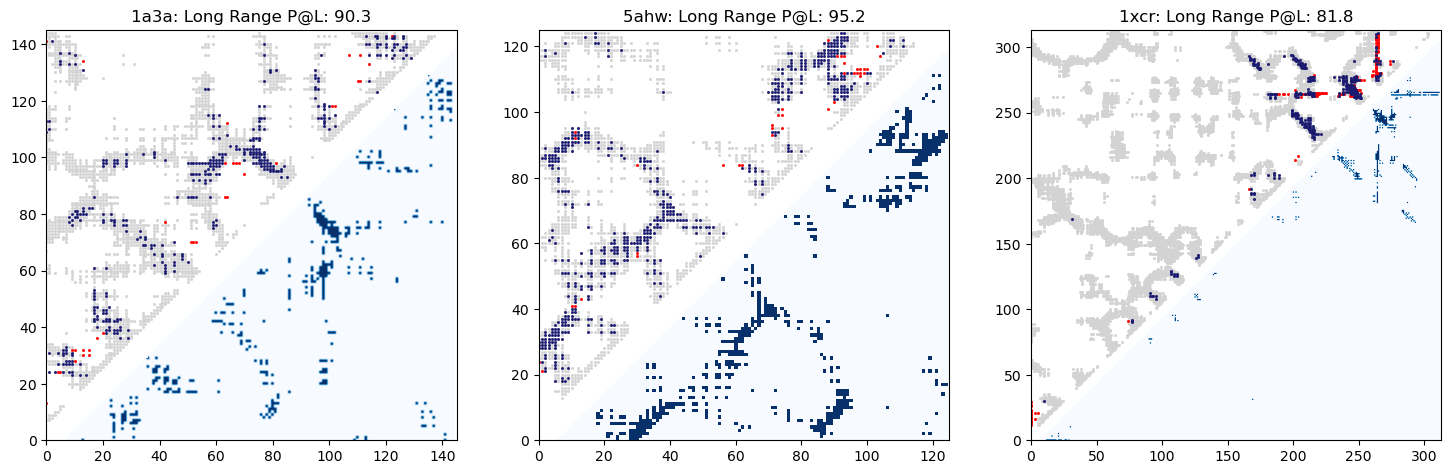

In [33]:
fig, axes = plt.subplots(figsize=(18, 6), ncols=3)
for ax, name in zip(axes, PDB_IDS):
    prediction = esm2_predictions[name] > 0.5
    target = contacts[name]
    plot_contacts_and_predictions(
        prediction, target, ax=ax, title = lambda prec: f"{name}: Long Range P@L: {100 * prec:0.1f}"
    )
plt.show()

In [ ]:
# Model O 

In [45]:
esm2_predictions = {}
esm2_results = []
for name, inputs in sequences.items():
    esm2_batch_labels, esm2_batch_strs, esm2_batch_tokens = esm2_batch_converter([inputs])
    esm2_batch_tokens = esm2_batch_tokens.to(next(esm2.parameters()).device)
    esm2_predictions[name] = esm2.predict_contacts(esm2_batch_tokens)[0].cpu()
    metrics = {"id": name, "model": "ESM-2 (Unsupervised)"}
    metrics.update(evaluate_prediction(esm2_predictions[name], contacts[name]))
    esm2_results.append(metrics)
esm2_results = pd.DataFrame(esm2_results)
display(esm2_results)

,id,model,M_AUC,M_P@L,M_P@L2,M_P@L5,L_AUC,L_P@L,L_P@L2,L_P@L5,XL_AUC,XL_P@L,XL_P@L2,XL_P@L5,XXL_AUC,XXL_P@L,XXL_P@L2,XXL_P@L5
0,1a3a,ESM-2 (Unsupervised),0.963736,0.917241,0.986111,1.000000,0.988568,0.958621,1.000000,1.000000,0.970778,0.910345,0.986111,1.0,0.781619,0.586207,0.833333,0.931035
1,5ahw,ESM-2 (Unsupervised),0.887230,0.784000,0.887097,1.000000,1.000000,1.000000,1.000000,1.000000,0.972091,0.888000,0.983871,1.0,0.814229,0.672000,0.822581,0.920000
2,1xcr,ESM-2 (Unsupervised),0.819145,0.693291,0.833333,0.887097,0.832496,0.725240,0.846154,0.951613,0.848058,0.702875,0.865385,1.0,0.747751,0.555911,0.743590,0.983871


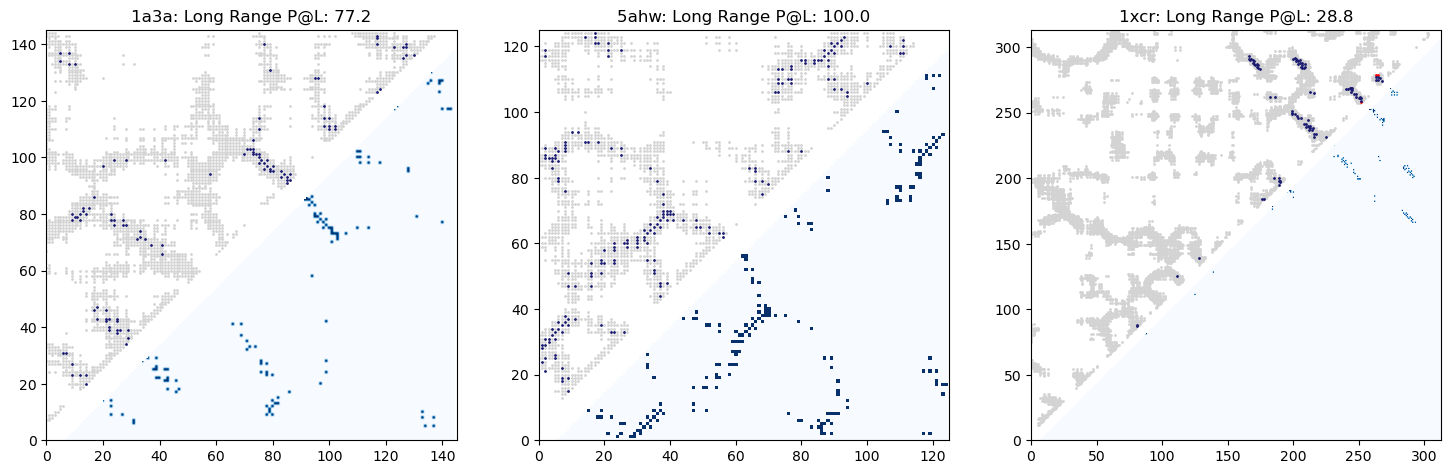

In [46]:
fig, axes = plt.subplots(figsize=(18, 6), ncols=3)
for ax, name in zip(axes, PDB_IDS):
    prediction = esm2_predictions[name] > 0.5
    target = contacts[name]
    plot_contacts_and_predictions(
        prediction, target, ax=ax, title = lambda prec: f"{name}: Long Range P@L: {100 * prec:0.1f}"
    )
plt.show()

In [ ]:
# FT V2

In [8]:
esm2_predictions = {}
esm2_results = []
for name, inputs in sequences.items():
    esm2_batch_labels, esm2_batch_strs, esm2_batch_tokens = esm2_batch_converter([inputs])
    esm2_batch_tokens = esm2_batch_tokens.to(next(esm2.parameters()).device)
    esm2_predictions[name] = esm2.predict_contacts(esm2_batch_tokens)[0].cpu()
    metrics = {"id": name, "model": "ESM-2 (Unsupervised)"}
    metrics.update(evaluate_prediction(esm2_predictions[name], contacts[name]))
    esm2_results.append(metrics)
esm2_results = pd.DataFrame(esm2_results)
display(esm2_results)

,id,model,M_AUC,M_P@L,M_P@L2,M_P@L5,L_AUC,L_P@L,L_P@L2,L_P@L5,XL_AUC,XL_P@L,XL_P@L2,XL_P@L5,XXL_AUC,XXL_P@L,XXL_P@L2,XXL_P@L5
0,1a3a,ESM-2 (Unsupervised),0.951697,0.868966,0.972222,1.00000,0.994850,0.986207,1.000000,1.000000,0.970774,0.931035,0.986111,1.000000,0.772997,0.606897,0.805556,0.931035
1,5ahw,ESM-2 (Unsupervised),0.888123,0.800000,0.887097,1.00000,1.000000,1.000000,1.000000,1.000000,0.961901,0.896000,0.983871,1.000000,0.839174,0.760000,0.854839,0.920000
2,1xcr,ESM-2 (Unsupervised),0.780878,0.690096,0.788462,0.83871,0.843944,0.753994,0.865385,0.951613,0.865401,0.763578,0.865385,0.967742,0.751022,0.616613,0.711538,0.903226


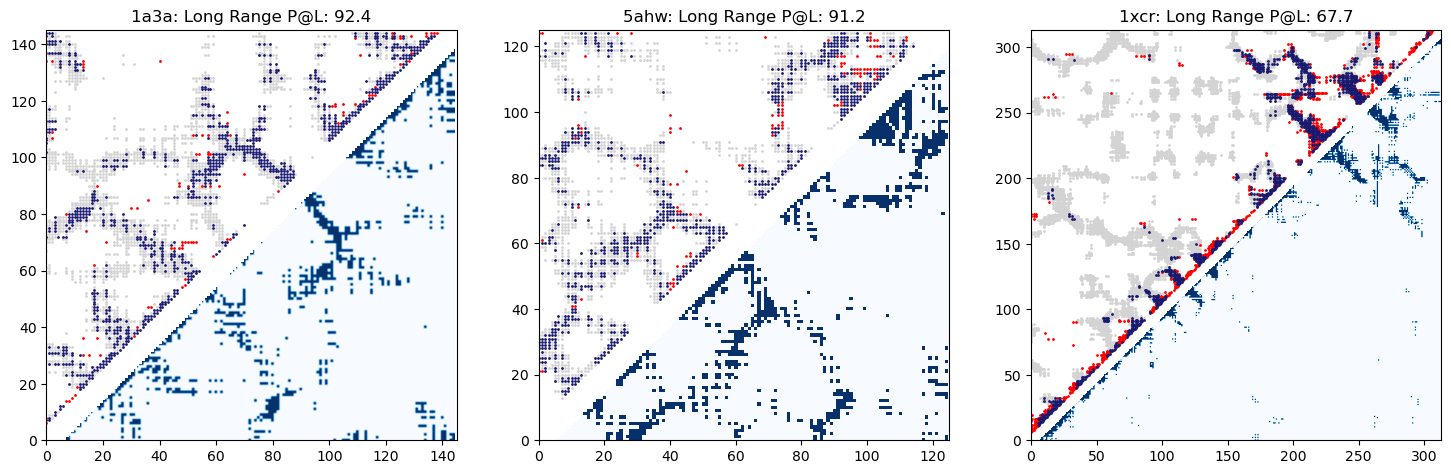

In [9]:
fig, axes = plt.subplots(figsize=(18, 6), ncols=3)
for ax, name in zip(axes, PDB_IDS):
    prediction = esm2_predictions[name] > 0.5
    target = contacts[name]
    plot_contacts_and_predictions(
        prediction, target, ax=ax, title = lambda prec: f"{name}: Long Range P@L: {100 * prec:0.1f}"
    )
plt.show()

In [ ]:
# FT V2

In [15]:
esm2_predictions = {}
esm2_results = []
for name, inputs in sequences.items():
    esm2_batch_labels, esm2_batch_strs, esm2_batch_tokens = esm2_batch_converter([inputs])
    esm2_batch_tokens = esm2_batch_tokens.to(next(esm2.parameters()).device)
    esm2_predictions[name] = esm2.predict_contacts(esm2_batch_tokens)[0].cpu()
    metrics = {"id": name, "model": "ESM-2 (Unsupervised)"}
    metrics.update(evaluate_prediction(esm2_predictions[name], contacts[name]))
    esm2_results.append(metrics)
esm2_results = pd.DataFrame(esm2_results)
display(esm2_results)

,id,model,M_AUC,M_P@L,M_P@L2,M_P@L5,L_AUC,L_P@L,L_P@L2,L_P@L5,XL_AUC,XL_P@L,XL_P@L2,XL_P@L5,XXL_AUC,XXL_P@L,XXL_P@L2,XXL_P@L5
0,6shx,ESM-2 (Unsupervised),0.729421,0.678423,0.721992,0.770833,0.687077,0.622407,0.697095,0.760417,0.542074,0.377593,0.53112,0.666667,0.766255,0.686722,0.775934,0.802083


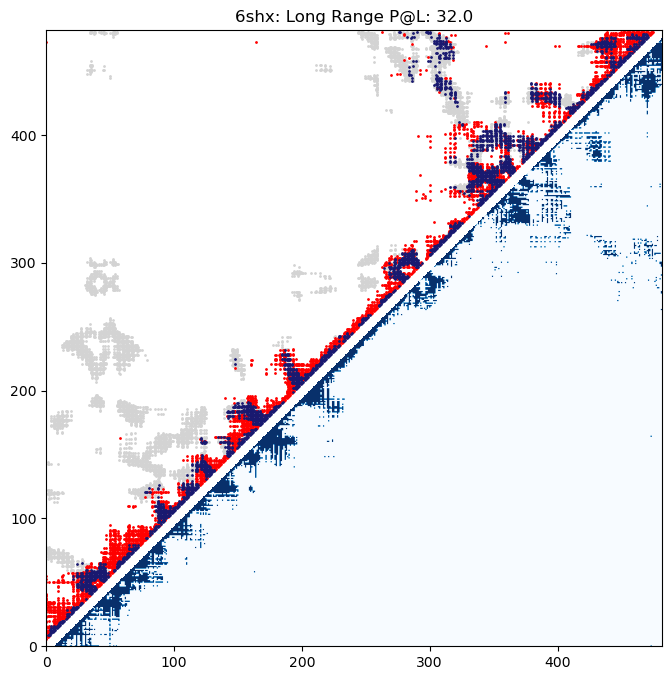

In [16]:
fig, axes = plt.subplots(figsize=(12, 8), ncols=1)
prediction = esm2_predictions[name] > 0.5
target = contacts[name]
plot_contacts_and_predictions(
    prediction, target, title = lambda prec: f"{name}: Long Range P@L: {100 * prec:0.1f}"
)
plt.show()

In [ ]:
# Model O

In [18]:
esm2_predictions = {}
esm2_results = []
for name, inputs in sequences.items():
    esm2_batch_labels, esm2_batch_strs, esm2_batch_tokens = esm2_batch_converter([inputs])
    esm2_batch_tokens = esm2_batch_tokens.to(next(esm2.parameters()).device)
    esm2_predictions[name] = esm2.predict_contacts(esm2_batch_tokens)[0].cpu()
    metrics = {"id": name, "model": "ESM-2 (Unsupervised)"}
    metrics.update(evaluate_prediction(esm2_predictions[name], contacts[name]))
    esm2_results.append(metrics)
esm2_results = pd.DataFrame(esm2_results)
display(esm2_results)

,id,model,M_AUC,M_P@L,M_P@L2,M_P@L5,L_AUC,L_P@L,L_P@L2,L_P@L5,XL_AUC,XL_P@L,XL_P@L2,XL_P@L5,XXL_AUC,XXL_P@L,XXL_P@L2,XXL_P@L5
0,6shx,ESM-2 (Unsupervised),0.73015,0.676349,0.717842,0.770833,0.690955,0.574689,0.697095,0.791667,0.486363,0.338174,0.46473,0.635417,0.754165,0.688797,0.746888,0.8125


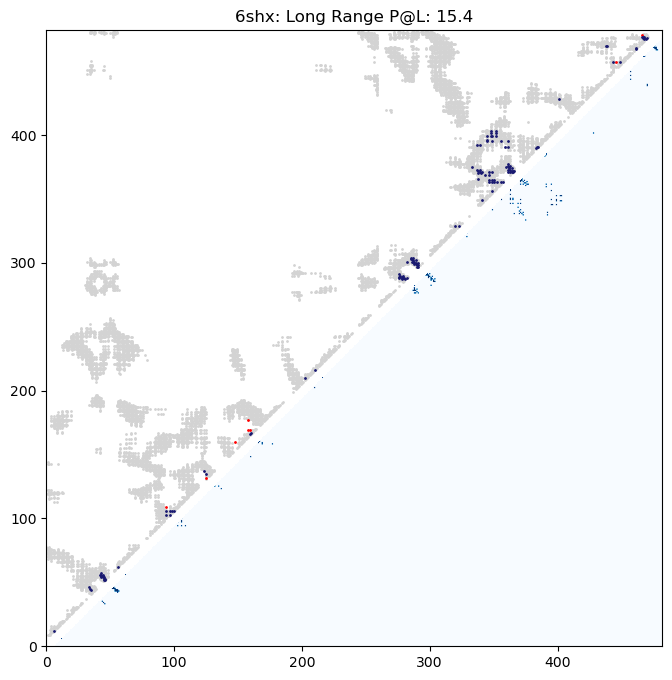

In [19]:
fig, axes = plt.subplots(figsize=(12, 8), ncols=1)
prediction = esm2_predictions[name] > 0.5
target = contacts[name]
plot_contacts_and_predictions(
    prediction, target, title = lambda prec: f"{name}: Long Range P@L: {100 * prec:0.1f}"
)
plt.show()

In [ ]:
# Model O

In [32]:
esm2_predictions = {}
esm2_results = []
for name, inputs in sequences.items():
    esm2_batch_labels, esm2_batch_strs, esm2_batch_tokens = esm2_batch_converter([inputs])
    esm2_batch_tokens = esm2_batch_tokens.to(next(esm2.parameters()).device)
    esm2_predictions[name] = esm2.predict_contacts(esm2_batch_tokens)[0].cpu()
    metrics = {"id": name, "model": "ESM-2 (Unsupervised)"}
    metrics.update(evaluate_prediction(esm2_predictions[name], contacts[name]))
    esm2_results.append(metrics)
esm2_results = pd.DataFrame(esm2_results)
display(esm2_results)

,id,model,M_AUC,M_P@L,M_P@L2,M_P@L5,L_AUC,L_P@L,L_P@L2,L_P@L5,XL_AUC,XL_P@L,XL_P@L2,XL_P@L5,XXL_AUC,XXL_P@L,XXL_P@L2,XXL_P@L5
0,4e4w,ESM-2 (Unsupervised),0.738308,0.632911,0.708861,0.893617,0.658687,0.559072,0.64557,0.734043,0.218929,0.189873,0.21519,0.265957,0.689818,0.666667,0.658228,0.723404


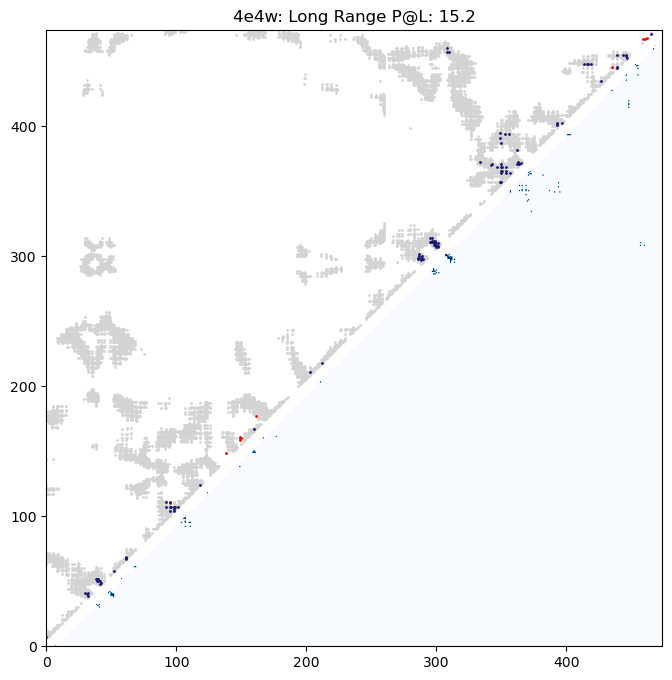

In [33]:
fig, axes = plt.subplots(figsize=(12, 8), ncols=1)
prediction = esm2_predictions[name] > 0.5
target = contacts[name]
plot_contacts_and_predictions(
    prediction, target, title = lambda prec: f"{name}: Long Range P@L: {100 * prec:0.1f}"
)
plt.show()

In [ ]:
# V1

In [26]:
esm2_predictions = {}
esm2_results = []
for name, inputs in sequences.items():
    esm2_batch_labels, esm2_batch_strs, esm2_batch_tokens = esm2_batch_converter([inputs])
    esm2_batch_tokens = esm2_batch_tokens.to(next(esm2.parameters()).device)
    esm2_predictions[name] = esm2.predict_contacts(esm2_batch_tokens)[0].cpu()
    metrics = {"id": name, "model": "ESM-2 (Unsupervised)"}
    metrics.update(evaluate_prediction(esm2_predictions[name], contacts[name]))
    esm2_results.append(metrics)
esm2_results = pd.DataFrame(esm2_results)
display(esm2_results)

,id,model,M_AUC,M_P@L,M_P@L2,M_P@L5,L_AUC,L_P@L,L_P@L2,L_P@L5,XL_AUC,XL_P@L,XL_P@L2,XL_P@L5,XXL_AUC,XXL_P@L,XXL_P@L2,XXL_P@L5
0,4e4w,ESM-2 (Unsupervised),0.636674,0.559072,0.624473,0.734043,0.48497,0.440928,0.464135,0.521277,0.161046,0.175105,0.189873,0.095745,0.518026,0.56962,0.531646,0.425532


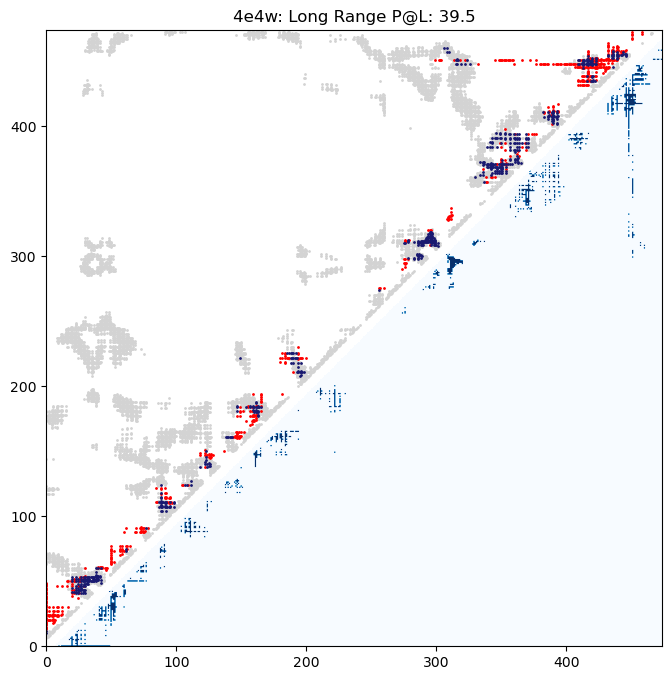

In [27]:
fig, axes = plt.subplots(figsize=(12, 8), ncols=1)
prediction = esm2_predictions[name] > 0.5
target = contacts[name]
plot_contacts_and_predictions(
    prediction, target, title = lambda prec: f"{name}: Long Range P@L: {100 * prec:0.1f}"
)
plt.show()

In [ ]:
# V2 

In [29]:
esm2_predictions = {}
esm2_results = []
for name, inputs in sequences.items():
    esm2_batch_labels, esm2_batch_strs, esm2_batch_tokens = esm2_batch_converter([inputs])
    esm2_batch_tokens = esm2_batch_tokens.to(next(esm2.parameters()).device)
    esm2_predictions[name] = esm2.predict_contacts(esm2_batch_tokens)[0].cpu()
    metrics = {"id": name, "model": "ESM-2 (Unsupervised)"}
    metrics.update(evaluate_prediction(esm2_predictions[name], contacts[name]))
    esm2_results.append(metrics)
esm2_results = pd.DataFrame(esm2_results)
display(esm2_results)

,id,model,M_AUC,M_P@L,M_P@L2,M_P@L5,L_AUC,L_P@L,L_P@L2,L_P@L5,XL_AUC,XL_P@L,XL_P@L2,XL_P@L5,XXL_AUC,XXL_P@L,XXL_P@L2,XXL_P@L5
0,4e4w,ESM-2 (Unsupervised),0.725274,0.639241,0.721519,0.755319,0.622602,0.544304,0.603376,0.691489,0.272467,0.185654,0.236287,0.361702,0.778699,0.64557,0.767932,0.904255


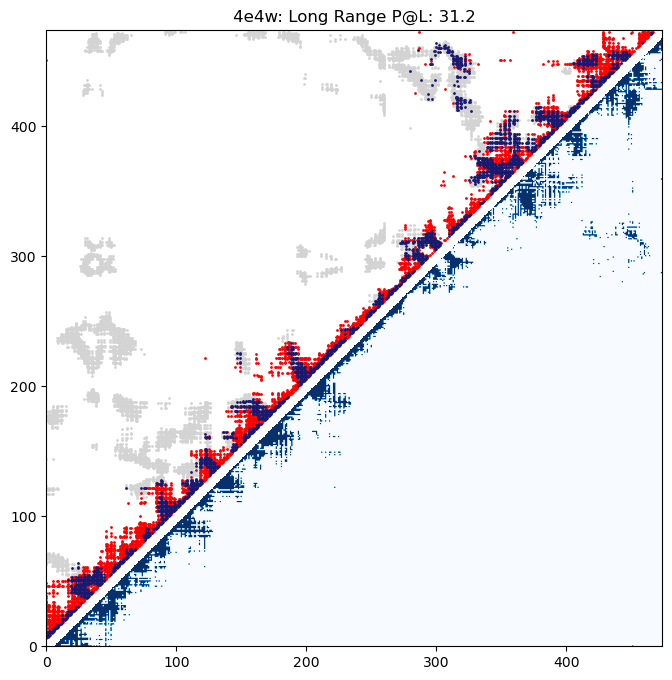

In [30]:
fig, axes = plt.subplots(figsize=(12, 8), ncols=1)
prediction = esm2_predictions[name] > 0.5
target = contacts[name]
plot_contacts_and_predictions(
    prediction, target, title = lambda prec: f"{name}: Long Range P@L: {100 * prec:0.1f}"
)
plt.show()